In [65]:
import os
# 完整的transformer encoder-decoder架构
from DataLoader import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
from torch.utils.data import DataLoader
from ProcessData import process_data3
import time

In [83]:
class Transformer(torch.nn.Module):
    # d_model : number of features
    def __init__(self, train_length, forcast_window):
        super(Transformer, self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2, 256, 8)
        self.encoder_layer = torch.nn.TransformerEncoderLayer(d_model=256, nhead=8, dropout=0.1)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.positional_embedding = torch.nn.Embedding(100, 256)
        # self.decoder_layer = nn.TransformerDecoderLayer(d_model=feature_size, nhead=1, dropout=dropout)
        # self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.decoder_layer = torch.nn.TransformerDecoderLayer(d_model=256, nhead=8, dropout=0.1)
        self.transformer_decoder = torch.nn.TransformerDecoder(self.decoder_layer, num_layers=4)
        self.fc1 = torch.nn.Linear(256, 1)
        self.train_length = train_length
        self.forcast_window = forcast_window
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        # torch.triu() 返回右上三角
        mask = (torch.triu(torch.ones(sz, sz)==1)).transpose(0,1)
        mask = mask.float().masked_fill(mask==0, float('-inf')).masked_fill(mask==1, float(0.0))
        return mask

    def _generate_forward_mask(self, sz):
        mask = torch.zeros(sz, sz)
        for i in range(self.train_length):
            mask[i][self.train_length:]=1
        for i in range(self.train_length, sz):
            mask[i][i+1:]=1
        mask = mask.float().masked_fill(mask==1, float('-inf'))
        return mask

    def forward(self, x, src, tar):
        mask = self._generate_square_subsequent_mask(tar.shape[1]).cuda()
        # print(src.shape) #[batch, time_step]
        # print(x.shape)
        x_enc = x[:, :self.train_length] #[batch, 30]
        x_dec = x[:, self.train_length-1:self.train_length-1+tar.shape[1]] #[batch, 7]
        z_enc = torch.cat((src.unsqueeze(1), x_enc.unsqueeze(1)), dim=1) #[batch, feature, time_step]
        z_enc_embedding = self.input_embedding(z_enc).permute(2,0,1) #[time_step, batch, feature]

        # [batch, time, feature] -> [time, batch, feature]
        enc_positional_embeddings = self.positional_embedding(x_enc.type(torch.long)).permute(1,0,2)

        z_dec = torch.cat((tar.unsqueeze(1), x_dec.unsqueeze(1)), dim=1)
        z_dec_embedding = self.input_embedding(z_dec).permute(2,0,1)
        dec_positional_embeddings = self.positional_embedding(x_dec.type(torch.long)).permute(1,0,2)
        # print(x_dec.type(torch.long))
        input_embedding = z_enc_embedding+enc_positional_embeddings
        tar_embedding = z_dec_embedding + dec_positional_embeddings
        enc_output = self.transformer_encoder(input_embedding)
        output = self.transformer_decoder(tgt=tar_embedding, memory=enc_output, tgt_mask=mask)
        # output = self.decoder(tgt=src, memory=output)
        output = self.fc1(output.permute(1,0,2)) #【batch, time, 1】
        return output

In [84]:
train_length = 30
forcast_window = 7
csv_name = "Palo Alto"

In [4]:
train_dataset, test_dataset, X_train_time, X_test_time = process_data3(csv_name,train_length, forcast_window, time=True)

F:\我的文件\EV充电需求\Deep-Spatio-Temporal-Forecasting\data_handler.py:22: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  Palo_alto = pd.read_csv("data/Palo Alto/ChargePoint Data CY20Q4.csv")


<class 'numpy.ndarray'>
normalized.shape: (3444,)
matrix_lags.shape: (3407, 37)
train_dataset: (3400, 37)
test_dataset: (7, 37)
time_list: (3444,)
all_time_lags.shape: (3407, 37)


In [5]:
criterion = torch.nn.MSELoss()

In [6]:
def Dp(y_pred,y_true,q): # softmax更新
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

In [7]:
def Rp_num_den(y_preds,y_trues,q): # RPloss
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

/title 需要的预测数据类型， src = [batch, 30], tar=[batch, 8]

In [8]:
train_data = SensorDataset4(train_dataset, X_train_time, train_length, forcast_window)
test_data = SensorDataset4(test_dataset, X_test_time, train_length, forcast_window)

torch.Size([3400, 30])
torch.Size([3400, 8])
torch.Size([3400, 37])
(3400, 37)
torch.Size([7, 30])
torch.Size([7, 8])
torch.Size([7, 37])
(7, 37)


F:\我的文件\EV充电需求\Deep-Spatio-Temporal-Forecasting\DataLoader.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


In [9]:
train_dl = DataLoader(train_data,batch_size=32,shuffle=True) # [batch_size, feature_size]
test_dl = DataLoader(test_data,batch_size=1)

In [85]:
model = Transformer(train_length, forcast_window).cuda()

In [99]:
lr = 0.000005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 10000

In [80]:
def train_epoch(model,train_dl,train_length=30):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,src,tar, times) in enumerate(train_dl):
        # [batch, time]
        tar_in = tar[:,:-1]
        tar_out = tar[:,1:]
        optimizer.zero_grad()
        output = model(x.cuda().float(),src.cuda().float(),tar_in.cuda())
        # output [batch, forcast_window, 1]
        # print('output:',output[0])
        # print('tar_out:', tar_out[0])
        loss = criterion(output.squeeze(-1),tar_out.cuda()) # not missing data
        loss.backward()
        optimizer.step()
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [81]:
def test_epoch(model,test_dl,train_length=30, forcast_window=7):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,src,tar,times) in enumerate(test_dl):
            tar_in = src[:,-1].unsqueeze(-1)
            tar_out = tar[:,1:]
            next_input = torch.tensor(tar_in)
            all_predictions = []

            for i in range(forcast_window):
                output = model(x.cuda(),src.cuda(), next_input.cuda())
                if all_predictions == []:
                    all_predictions = output[:,-1].detach()
                else:
                    all_predictions = torch.cat((all_predictions, output[:,-1].detach()), dim=-1)
                next_input = torch.cat((next_input.cuda(), output[:,-1].detach()), dim=-1)
            # print('output:',output[0])
            # print('tar_out:', tar_out[0])
            # print(output.shape) #[batch, seq_len, feature] [128, 48, 1]
            # print('test:', output[0,(train_length-1):(train_length+forcast_window-1)])
            for p,o in zip(all_predictions.cpu().numpy(),tar_out.numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
    return Rp

In [100]:
train_epoch_loss = []
# eval_loss = []
Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    start = time.time()
    train_loss = []

    l_t = train_epoch(model,train_dl,train_length)
    train_loss.append(l_t)

    Rp = test_epoch(model,test_dl,train_length, forcast_window)

    if Rp_best > Rp:
        Rp_best = Rp

    train_epoch_loss.append(np.mean(train_loss))
    end = time.time()
    print("Epoch {}: Train loss: {} \t R_p={}\tcost_time={}".format(e+1,
                                                             np.mean(train_loss),Rp,end-start))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16344\2408316568.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_input = torch.tensor(tar_in)


Epoch 1: Train loss: 0.0006173123387784204 	 R_p=0.4213722553923739	cost_time=4.55735445022583
Epoch 2: Train loss: 0.0006178985510076232 	 R_p=0.42315183502115844	cost_time=4.340293884277344
Epoch 3: Train loss: 0.000624464766588062 	 R_p=0.43884822916755706	cost_time=4.381798028945923
Epoch 4: Train loss: 0.0006179253774804666 	 R_p=0.44320729033151113	cost_time=4.308855295181274
Epoch 5: Train loss: 0.0006079226118676802 	 R_p=0.4477394408023205	cost_time=4.372121334075928
Epoch 6: Train loss: 0.000611774737617987 	 R_p=0.449074270088098	cost_time=4.335617303848267
Epoch 7: Train loss: 0.0006115076729260823 	 R_p=0.4434725129993337	cost_time=4.30382513999939
Epoch 8: Train loss: 0.0006186602691955426 	 R_p=0.43404315701655616	cost_time=4.311917066574097
Epoch 9: Train loss: 0.0006113305355093496 	 R_p=0.43719288611966084	cost_time=4.361607551574707
Epoch 10: Train loss: 0.0006059883200727842 	 R_p=0.43137952029122234	cost_time=4.381507873535156
Epoch 11: Train loss: 0.00060447142630

In [89]:
print("Rp best={}".format(Rp_best))

Rp best=0.34532115199362745


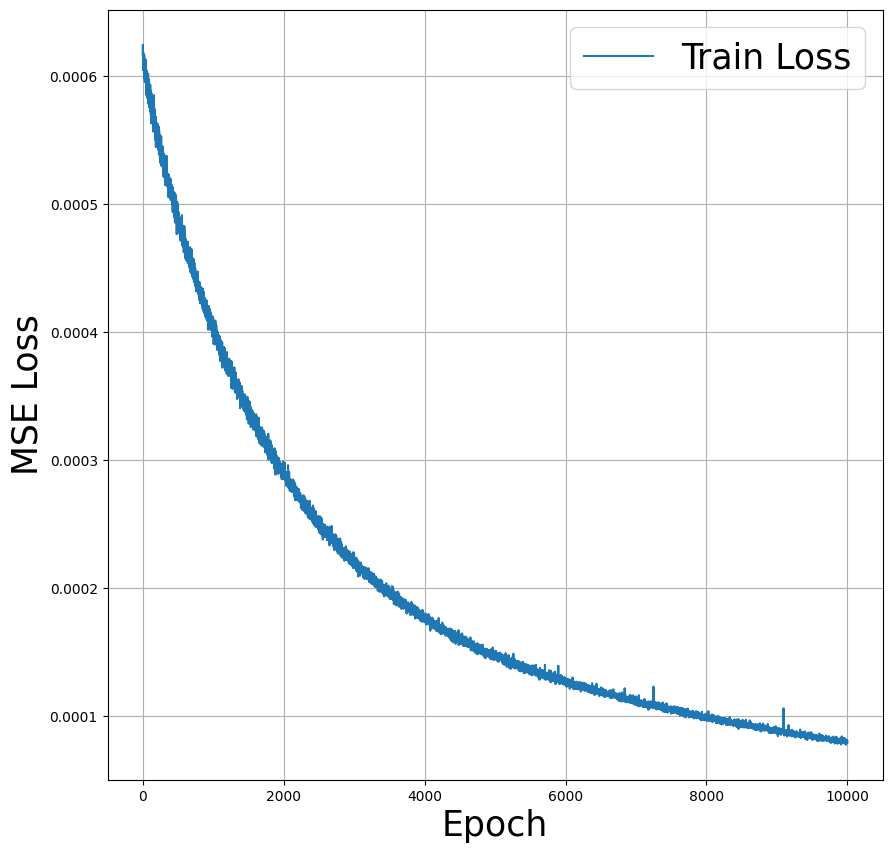

In [102]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.legend(['Train Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.grid()
plt.show()

In [91]:
def change_to_date(date_num): # 更改数字日期到真实日期
    date_num = date_num.cpu().numpy()
    date_list = []
    for date in date_num:
        date_list.append(str(date)[:4]+'-'+str(date)[4:6]+'-'+str(date)[6:8])
    return date_list

In [101]:
torch.save(model,'save_model4/full_transformer_10000.pth')

7


F:\ENV_py\PYTORCH\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


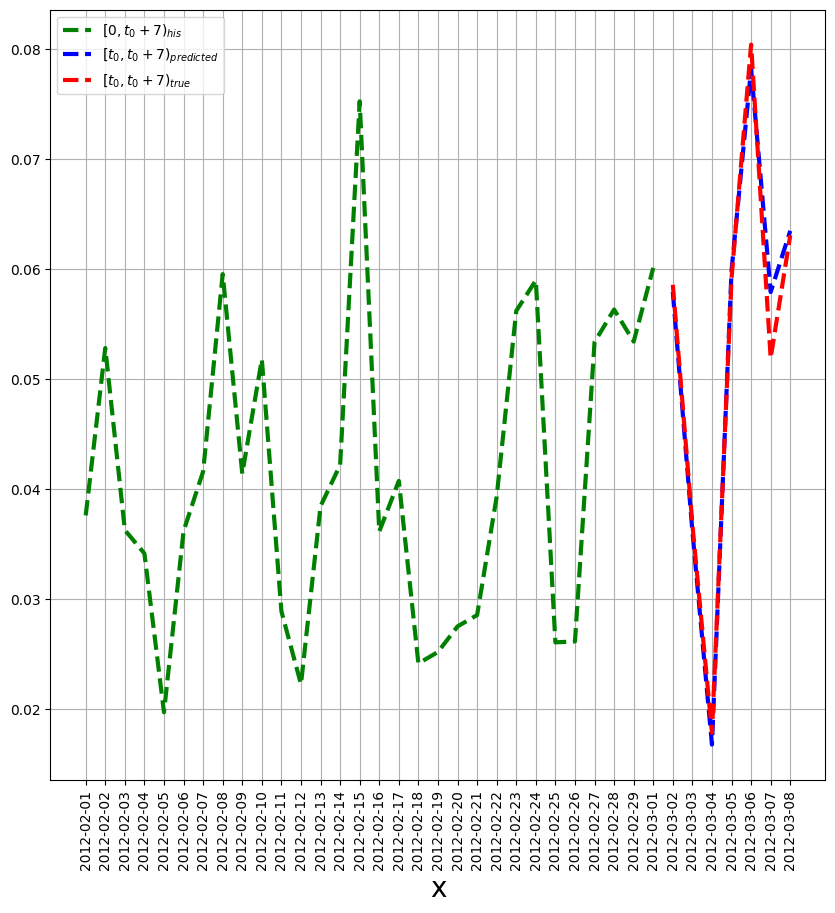

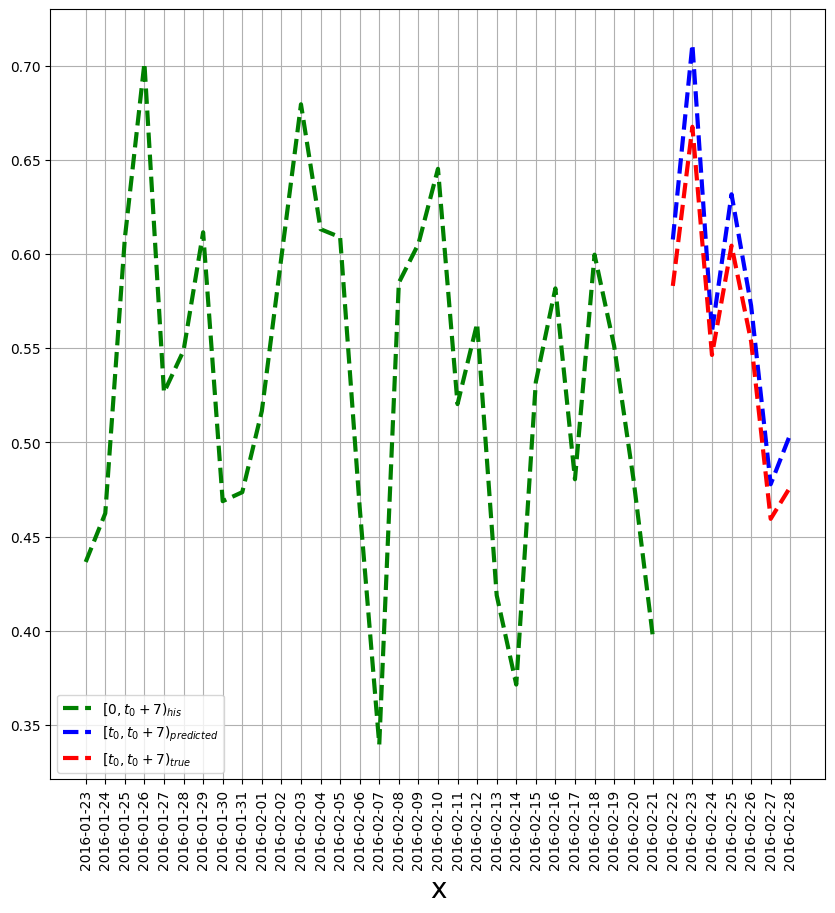

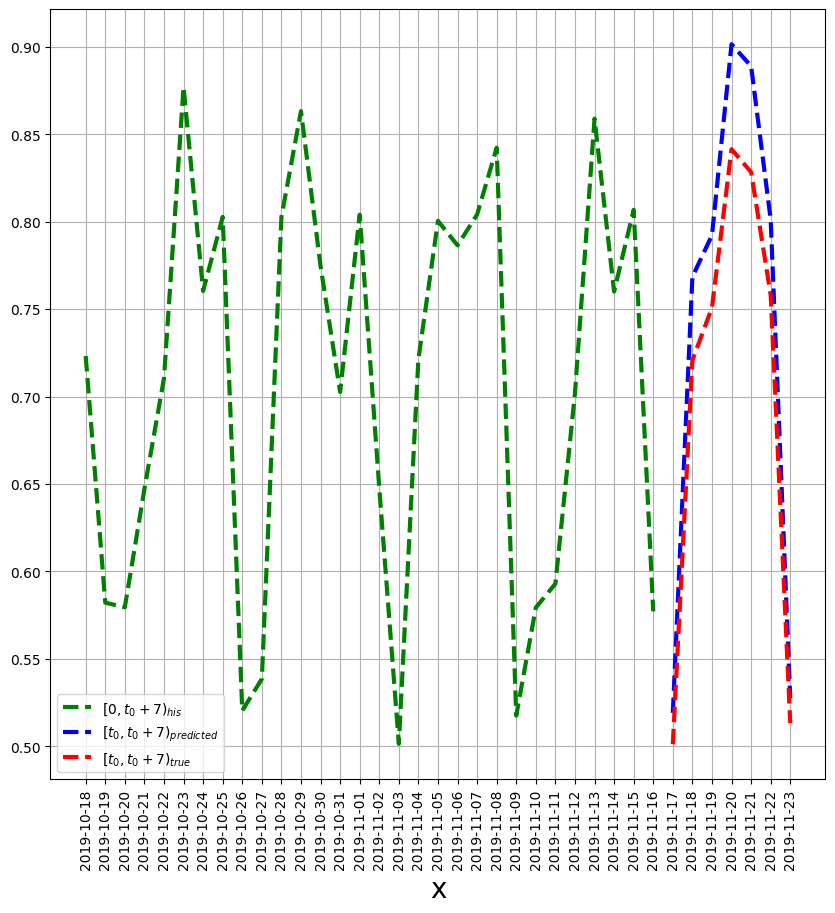

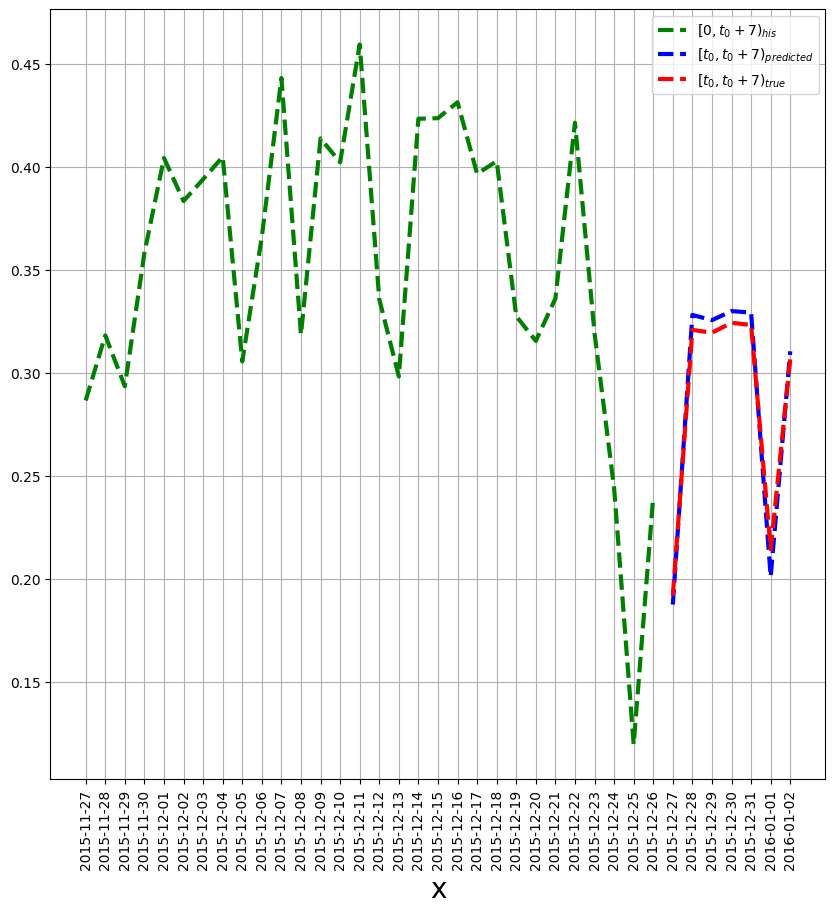

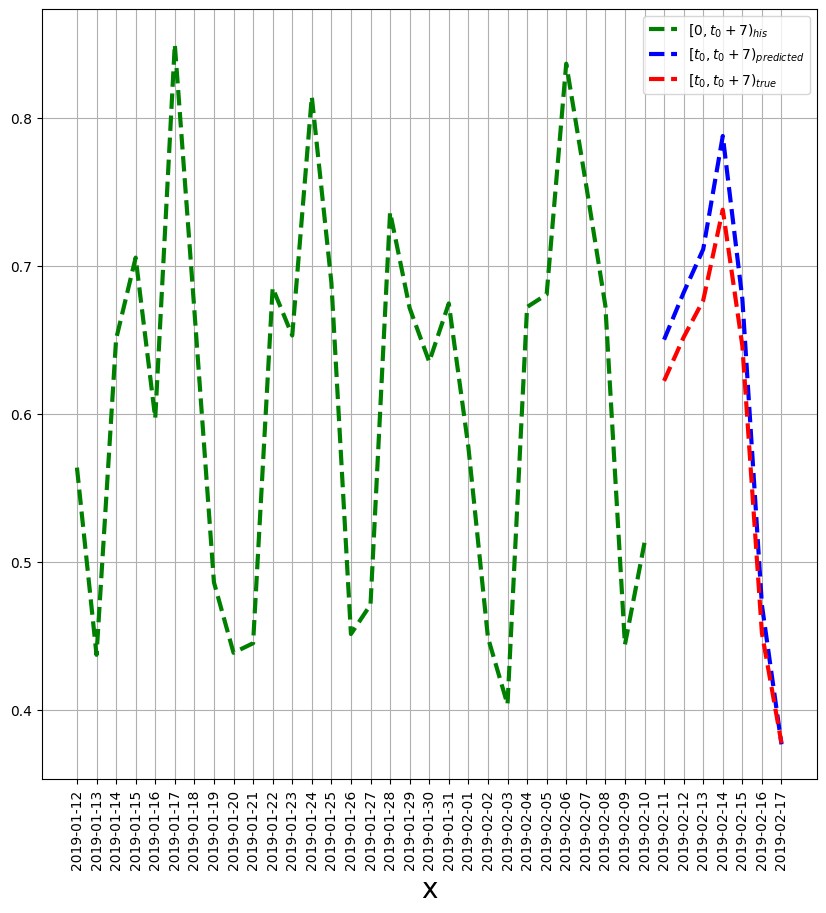

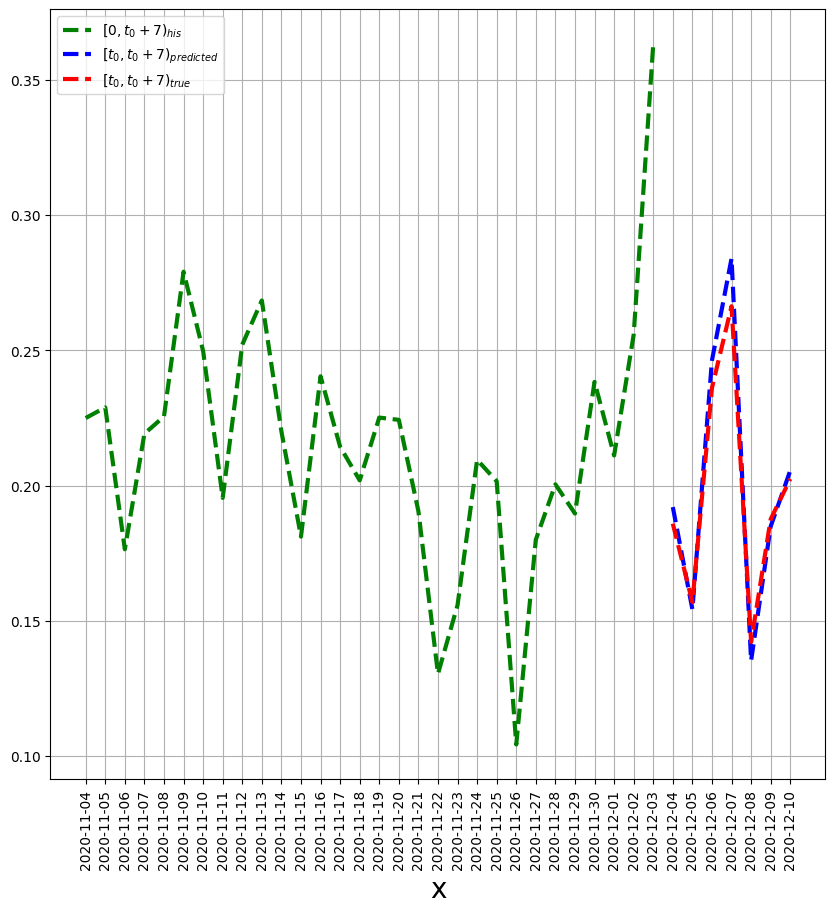

In [104]:
n_plots = 5
with torch.no_grad():
    model.eval()
    # test_model.eval()
    print(len(test_dl))
    for step,(x,src, tar, times) in enumerate(train_dl):
        tar_in = src[:,-1].unsqueeze(-1) # 取最后一个日子的输入当作transformer的起始输入
        tar_out = tar[:,1:]
        next_input = tar_in
        all_predictions = []
        for i in range(forcast_window):
            output = model(x.cuda().float(),src.cuda(), next_input.cuda().float())
            if all_predictions==[]:
                all_predictions = output[:,-1]
            else:
                all_predictions = torch.cat((all_predictions, output[:,-1].detach()),dim=-1)
            next_input = torch.cat((next_input.cuda(), output[:,-1]), dim=-1)
        # x[batch, seq_len]
        # y[batch, seq_len]
        if step > n_plots:
            break

        with torch.no_grad():
            plt.figure(figsize=(10,10))
            data_list = change_to_date(times[0])
            plt.xticks(x[0], data_list)
            plt.xticks(rotation=90)
            plt.plot(x[0][:src.shape[1]].cpu().detach().squeeze(-1).numpy(),src[0].cpu().detach().squeeze(-1).numpy(),'g--',linewidth=3)
            # plt.plot(x[0]+forcast_window,tar[0].cpu().detach().numpy(),'g--',linewidth=3)
            plt.plot(x[0][train_length:train_length+forcast_window],all_predictions[0,:].cpu().detach().numpy(),'b--',linewidth=3)
            plt.plot(x[0][train_length:train_length+forcast_window],
                     tar_out[0], 'r--', linewidth=3)# not missing data
            # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
            plt.xlabel("x",fontsize=20)
            plt.legend(["$[0,t_0+{7})_{his}$","$[t_0,t_0+{7})_{predicted}$","$[t_0,t_0+{7})_{true}$"])
            plt.grid()
            plt.show()

In [22]:
def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)==1)).transpose(0,1)
        mask = mask.float().masked_fill(mask==0, float('-inf')).masked_fill(mask==1, float(0.0))
        return mask

In [42]:
def get_attn(model,x,src, tar):
    model.eval()
    with torch.no_grad():
        x_in = x[:,:train_length]
        x_out = x[:,train_length-1:train_length-1+forcast_window]
        x_in =x_in.cuda(); src=src.cuda(); x_out = x_out.cuda()
        tar_in = tar[:,:-1].cuda()
        attention_masks = model._generate_square_subsequent_mask(tar_in.shape[1])
        attention_masks = attention_masks.cuda()
        z_enc = torch.cat((src.unsqueeze(1),x_in.unsqueeze(1)),1)
        z_enc_embedding = model.input_embedding(z_enc).permute(2,0,1) # (sequence len,Batch size,embedding_size)
        enc_positional_embeddings = model.positional_embedding(x_in.type(torch.long)).permute(1,0,2)
        input_embedding = z_enc_embedding+ enc_positional_embeddings
        enc_out = model.transformer_encoder(input_embedding)
        z_dec = torch.cat((tar_in.unsqueeze(1),x_out.unsqueeze(1)),1)
        z_dec_embedding = model.input_embedding(z_dec).permute(2,0,1)
        dec_positional_embeddings = model.positional_embedding(x_out.type(torch.long)).permute(1,0,2)
        tar_embedding = z_dec_embedding + dec_positional_embeddings
        attn_layer_i = []
        for layer in model.transformer_decoder.layers:
            print(tar_embedding.shape)
            print(enc_out.shape)
            print(layer.self_attn(tar_embedding, enc_out,enc_out)[-1].shape)
            print(layer.self_attn(tar_embedding,enc_out,enc_out))
            # print(len(layer.self_attn(enc_out,enc_out,tar_embedding,attn_mask=attention_masks)))
            #[2, batch, seq_len_dec, seq_len_enc]
            #[num_head?, batch, seq_len_dec, seq_len_enc]
            attn_layer_i.append(layer.self_attn(tar_embedding,enc_out,enc_out)[-1].squeeze().cpu().detach().numpy())
            tar_embedding = layer.forward(tar_embedding,enc_out)

        return attn_layer_i

In [24]:
idx_example = 0

In [105]:
attn_layers = get_attn(model,test_data[idx_example][0].unsqueeze(0),test_data[idx_example][1].unsqueeze(0),test_data[idx_example][2].unsqueeze(0))

torch.Size([7, 1, 256])
torch.Size([30, 1, 256])
torch.Size([1, 7, 30])
(tensor([[[ 0.0173,  0.1108,  0.0227,  ...,  0.4544, -0.6196,  0.3202]],

        [[ 0.0820,  0.0476,  0.2034,  ...,  0.4987, -0.7472,  0.3223]],

        [[ 0.0920,  0.2137,  0.0514,  ...,  0.4145, -0.6452,  0.3857]],

        ...,

        [[ 0.0619,  0.1150, -0.0625,  ...,  0.3551, -0.2842,  0.5147]],

        [[ 0.0681,  0.1620, -0.2857,  ...,  0.3184, -0.5338,  0.2168]],

        [[ 0.0544,  0.0586, -0.1517,  ...,  0.3524, -0.4017,  0.3552]]],
       device='cuda:0'), tensor([[[0.0219, 0.0380, 0.0374, 0.0281, 0.0308, 0.0441, 0.0277, 0.0428,
          0.0375, 0.0278, 0.0237, 0.0335, 0.0809, 0.0372, 0.0307, 0.0276,
          0.0335, 0.0228, 0.0449, 0.0282, 0.0327, 0.0416, 0.0320, 0.0378,
          0.0217, 0.0307, 0.0262, 0.0385, 0.0250, 0.0150],
         [0.0439, 0.0653, 0.0337, 0.0245, 0.0189, 0.0404, 0.0212, 0.0285,
          0.0242, 0.0176, 0.0172, 0.0295, 0.0749, 0.0613, 0.0407, 0.0183,
          0.0340, 0.0

attn_layer.shape: (7, 30)


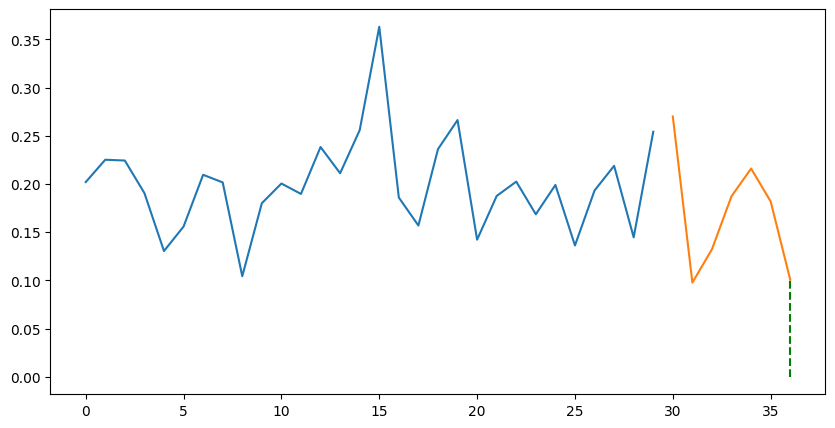

<Figure size 1000x1000 with 0 Axes>

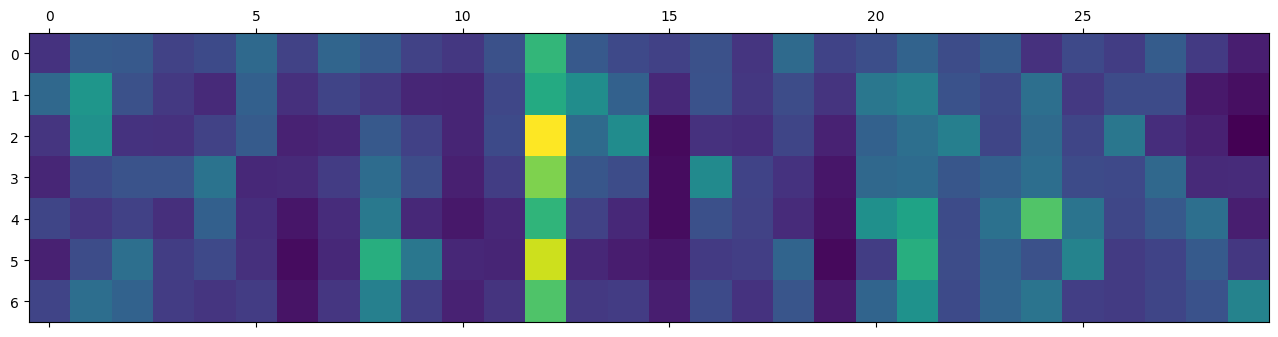

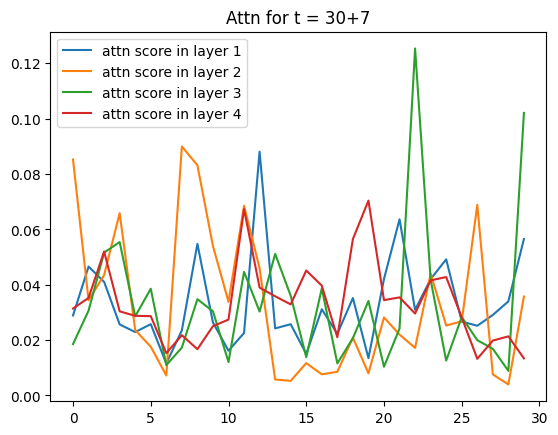

In [106]:
plt.figure(figsize=(10,5))
plt.plot(test_data[idx_example][0].numpy()[:train_length],test_data[idx_example][1].numpy())
plt.plot(test_data[idx_example][0].numpy()[train_length:train_length+forcast_window],test_data[idx_example][2][1:].numpy())
plt.plot([train_length+forcast_window-1,train_length+forcast_window-1],[0,0.1],'g--') # not missing data
# plt.plot([t0+24-1,t0+24-1],[20,120],'g--') # missing data
plt.figure(figsize=(10,10))
print('attn_layer.shape:', attn_layers[0].shape)
plt.matshow(attn_layers[0])
plt.figure()
plt.plot(attn_layers[0][forcast_window-1]) # not missing data
plt.plot(attn_layers[1][forcast_window-1]) # not missing data
plt.plot(attn_layers[2][forcast_window-1])
plt.plot(attn_layers[3][forcast_window-1]) # not missing data

#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[0][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[1][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[2][119-10]) # missing data



plt.legend(["attn score in layer 1","attn score in layer 2","attn score in layer 3","attn score in layer 4"])
plt.title("Attn for t = 30+7") # not missing data

plt.show()